<a href="https://colab.research.google.com/github/DannMacias/ztm_pytorch/blob/main/02_pytorch_nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> PyTorch Neural Nework Classification </b>

A **classification problem** involves predicting whether something is one thing or another.

In statistics, classification is the problem of identifying which a set of categories an observations belongs to.

> In machine learning, the observations are often known as **instances**, the independent variables are termed **features** (grouped into a feature vector), and the possible categories to be predicted are **classes**.

For example, you might want to:

|**Problem type**|**What is it?**|**Example**|
|-|-|-|
|**Binary classification**|Target can be one of two options|Predict whether or not someone has heart disease|
|**Multi-class classification**|Target can be one of more than two options|Decide whether a photo is of food, a person or a dog|
|**Multi-label classification**|Target can be assigned more than one option|Predict what categories should be assigned to a Wikipedia article|


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png" alt="a pytorch workflow flowchart" width=900/>

# 0) Architecture of a classification neural network

General architecture of a classification neural network.

|**Hyperparameter**|**Binary classification**|**Multiclass classification**|
|-|-|-|
|**Input layer shape (`in_features`)**|Same as number of features|Same as binary classification|
|**Hidden layer(s)**|Problem specific (from 0 to unlimited)|Same as binary classification|
|**Neurons per hidden layer**|Problem specific (from 10 to 512)|Same as binary classification|
|**Output layers shape (`out_features`)**|1 (one class)|1 per class (e.g., 3 for food, person or dog photo)|
|**Hidden layer activation**|Usually ReLU but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions)| Same as binary classification|
|**Output activation**| [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) (`torch.sigmoid`)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) (`torch.softmax`)|
|**Loss function**|[Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (`torch.nn.BCELoss`)|Cross entropy (`torch.nn.CrossEntropyLoss`)|
|**Optimizer**|[SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (Stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)|Same as binary classification|

> **Sniped code**:
>
> ```
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(model(input), target).backward()
optimizer.step()
> ```


# 1) Data for binary classification

We'll use the `make_circles()` method from Scikit-learn to generate two circles with different coloured dots.

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) # keep random state so we get the same values

In [ ]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label" : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


It looks like each pair of `X` features (`X1` and `X2`) has a label (`y`) value of either 0 or 1.

This tell us that our problem is **binary classification** since there's only two options (0 or 1).

In [ ]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

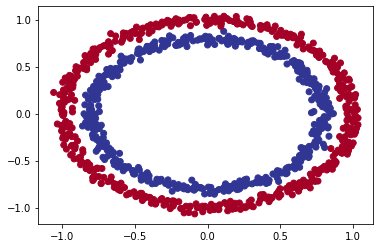

In [ ]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

> **Note**: This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.

## 1.1. Input and output shapes

In [ ]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and lables
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar).

We have two inputs for one output.

## 1.2. Turn data into tensors and create train and test splits

We'll need to:
1. Turn our data into tensors.
2. Split our data into training and test sets.

In [ ]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five examples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

We'll use `test_size=0.2` (80% training, 20% test) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [ ]:
# Split the data into train and test spli
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2) Building a PyTorch classification model

We'll break it down into a few parts.
1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop.


In [ ]:
# Standard PyTorch imports
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Given `X` (features) we want our model to predict `y` (label).

This setup where you have features and labels is referred to as **supervised learning**. Because your data is telling yout model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of `X` and `y`.

Let's create a model class that:
1. Subclasses `nn.Module`.
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

  # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instances of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between `self.layer_1` and `self.layer_2`.

`self.layer_1` takes 2 input features (`in_features=2`) and produces 5 output features (`out_features=5`).

This is known as having 5 **hidden units** or **neurons**.

This layer turns the input data from having 2 features to 5 features.

**Why do this?** - This allows the model to learn patterns from 5 numbers rather than just 2 numbers, *potentially* leading to better outputs.

* The number of hidden units you can use in neural networks layers is a **hyperparameter** (a value you can set yourself) and there's no set in stone value you have to use.

* Generally more is better but there's also such thing as too much. The amount you choose will depend on your model type and dataset you're working with.

The only rule with hidden units is that the next layer, in our case, `self.layer_2` has to take the same `in_features` as the previous layer `out_features`.

That's why `self.layer_2` has `in_features=5`, it takes the `out_features=5` from `self.layer_1` and performs a linear computation on them, turning them into `out_features=1` (the same shape as `y`).

You can aslo do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), which performs a forward pass computation of the input data through the layers in the order they appear.

In [ ]:
# Replicare CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

> **Why not just always use `nn.Sequential`?**
>
>`nn.Sequential` is fantastic for straight-forward computations, however, the namespace says, it *always* runs in sequential order.
>
>So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [ ]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Lenght of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Lenght of predictions: 200, Shape: torch.Size([200, 1])
Lenght of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.5226],
        [0.4678],
        [0.8397],
        [0.4321],
        [1.1149],
        [1.0793],
        [0.7068],
        [0.8507],
        [0.8276],
        [0.4672]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1. Setup loss function and optimizer

For binary classification problem, you'll often use **binary cross entropy** as the loss function.

And for optmizer, you'll often use stochastinc gradient descent (SGD, `torch.optim.SGD()`) or the Adam optimizer (`torch.optim.Adam()`).

|**Loss function/Optimizer**|**Problem type**|**PyTorch Code**|
|-|-|-|
|Stochastic Gradient Descent (SGD) optimizer|Classification, regression, many others|`torch.optim.SGD()`|
|Adam optimizer|Classification, regression, many others|`torch.optim.Adam()`|
|Binary cross entropy loss|Binary classification|`torch.nn.BCELossWithLogits` or `torch.nn.BCELoss`|
|Cross entropy loss|Multi-class classification|`torch.nn.CrossEntropyLoss`|
|MAE or L1 loss|Regression|`torch.nn.L1Loss`|
|MSE or L2 loss|Regression|`torch.nn.MSELoss`|

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note**: Recall a **loss function** is what measures *how wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss function as "loss criterion" or "criterion", these are all diferent ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in.

**Which one should you use?**

The documentation for `torch.nn.BCEWithLogitsLoss()` states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()`.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid built-in

# Creat an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Evaluation metric

If a loss function measures how *wrong* your model is, I like to think of evaluation metrics as measuring how *right* it is.

There are several evaluation metrics that can be used for classification problems but let's start our with **accuracy**.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predicctions.

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

# 3) Fitting the model to data (training)

## 3.1. Going from raw model outputs to predicted lables

Before we training loop steps, let's see what comes out of our model during the forward pass.

In [ ]:
# View the first 5 outputs of the forward pass on test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5226],
        [0.4678],
        [0.8397],
        [0.4321],
        [1.1149]], device='cuda:0', grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But *what* are they? They're the output of our `forward()` method. Which implements two layers of `nn.Linear()` which internally calls the following equation:

$$
\bf{y} = \bf{x}\cdot\bf{W}^{\top} + \bf{b}
$$

The *raw outputs* (unmodified) of this equations ($\bf{y}$) and in turn, the raw outputs of our model are often referred to as **logits**.

> **Note**:[Logits interpreted to be the unnormalised](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045) (or not-yet normalised) predictions (or outputs) of a model. These can give results, but we don't normally stop with logits, because interpreting their raw values is not easy.
>
> **Logits -> prediction probabilities -> prediction labels**

That's what our model is outputing above when it takes in the input data ($\bf{x}$ in the equation of or `X_test` in the code), logits.

However, these numbers are hard to interpret. We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the **sigmoid activation function**

$$
\text{Sigmoid}(x)=\sigma(x)=\frac{1}{1+\exp(-x)}
$$

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6278],
        [0.6149],
        [0.6984],
        [0.6064],
        [0.7530]], device='cuda:0', grad_fn=<SigmoidBackward0>)

They're now in the form of **prediction probabilities** (`y_pred_probs`), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1. So these values can be viewed as a decision boundary.
* If `y_pred_prons > 0.5`, `y = 1` (class 1)
* If `y_pred_prons < 0.5`, `y = 0` (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

Now it looks like our model's predictions are in the same form as our truth lables (`y_test`).

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our models prediction to the test labels to see how well it's going.

To recap, we converted our model's raw outputs (logits) to prediction probabilites using a sigmoid activation function.

And then converted the prediction probabilities to prediction lables by rounding them.

> **Note**: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).
>
> And the use of the sigmoid activation function is not required when passing our model's raw output to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is beacause it works on the model's raw logits output), this is because it has a sigmoid function built-in.

## 3.2. Building a training and testing loop

Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra 1 dimensions, this won't work unless model and data are on same device
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
  
  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) Using nn.BCELoss
  loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.78115, Accuracy: 50.00% | Test loss: 0.75850, Test acc: 50.00%
Epoch: 10 | Loss: 0.72162, Accuracy: 50.00% | Test loss: 0.71026, Test acc: 50.00%
Epoch: 20 | Loss: 0.70369, Accuracy: 50.12% | Test loss: 0.69658, Test acc: 52.50%
Epoch: 30 | Loss: 0.69783, Accuracy: 53.75% | Test loss: 0.69273, Test acc: 55.50%
Epoch: 40 | Loss: 0.69570, Accuracy: 51.88% | Test loss: 0.69178, Test acc: 53.00%
Epoch: 50 | Loss: 0.69478, Accuracy: 50.50% | Test loss: 0.69168, Test acc: 52.50%
Epoch: 60 | Loss: 0.69430, Accuracy: 49.88% | Test loss: 0.69183, Test acc: 51.50%
Epoch: 70 | Loss: 0.69400, Accuracy: 49.75% | Test loss: 0.69205, Test acc: 51.00%
Epoch: 80 | Loss: 0.69378, Accuracy: 49.62% | Test loss: 0.69229, Test acc: 51.00%
Epoch: 90 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69252, Test acc: 49.50%


It looks like the model went through the training and testing steps fine but the results don't seem to have moved so much.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing.

# 4) Making predictions and evaluating a model (inference)

Let's make a plot of our model's prediction, the data it's trying to predict on and the decision boundary it's creating for whether someting is class 0 or class 1.

To do so, we'll write some code to download and import the [`helper_function.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called `plot_decision_boundary()` which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll aslo import `plot_predictions()` whiche we wrote in notebook 01 to use later.

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist, skipping download


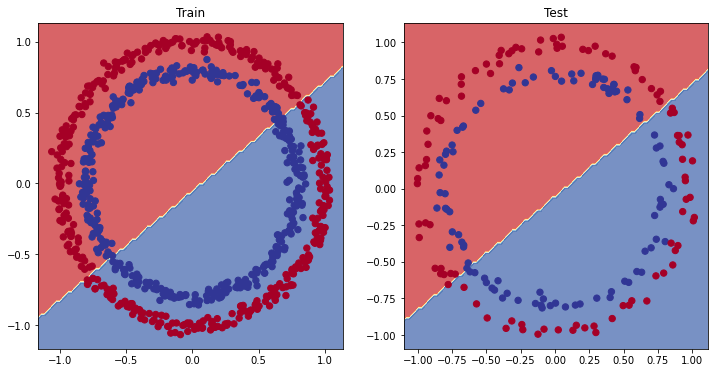

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line. That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

# 5) Improving a model (from a model perspective)

|**Model improvement technique**|**What does it do?**|
|-|-|
|**Add more layers**| Each layer *potentially* increaes the learning capabilities of the model, more layers = neural network *deeper*.|
|**Add more hidden units**| More hidden units per layer means a *potentially* increases in learning capabilities of the model, more hidden units = neural network *wider*.|
|**Fitting for longer (more epochs)**|Your model might learn more if it had more opportunities to look at the data.|
|**Changing the activation functions**|Linear activation vs. non-linear activation functions.|
|**Change the learning rate**|Too much and the model overcorrects, too little and it doesn't learn enough.|
|**Change the loss function**|Less model specific but still important, different problems require different loss functions.|
|**Use transfer learning**|Take a pretrained model from a problem domain similiar to yours and adjust it to your own problem.|

> **Note**: Because you can adjust all of these by hand, they're referred to as **hyperparameters**.
>
>And this is also where machine learning's **half art, half science** comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

Let's see what happens if we:
* add an extra layer to our model,
* fit the model for longer (`epochs = 1000`) and,
* increases the number of hidden units from `5` to `10`.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # Creating a model like this is the same as below, though below
    # generally benefits from speedups where possible.
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # Does not requiere sigmoid on input

# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predictions probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize.

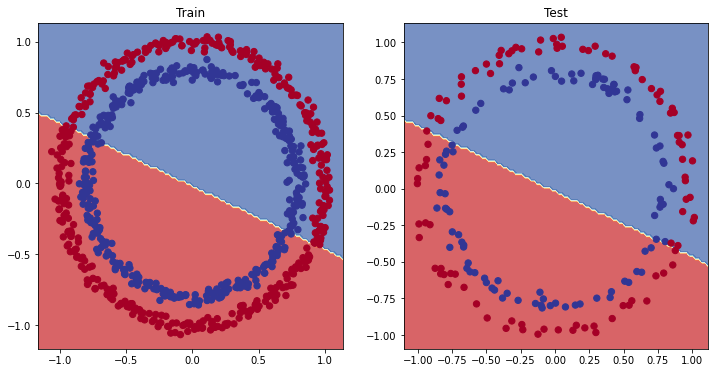

In [ ]:
# Plot decision boundary for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data?.

## 5.1. Preparing data to see if our model can model a straight line

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [ ]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
Y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], Y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test split
train_split = int(0.8 * len(X_regression))

X_train_regression, Y_train_regression = X_regression[:train_split], Y_regression[:train_split]
X_test_regression, Y_test_regression = X_regression[train_split:], Y_regression[train_split:]

# Check the lenghts of each split
print(len(X_train_regression),
      len(Y_train_regression),
      len(X_test_regression),
      len(Y_test_regression))

80 80 20 20


Let's see how the data looks.

To do so, we'll use the `plot_predictions()` function we created in notebook 01.

It's contained within the `helper_functions.py` script on the Learn PyTorch for Deep Learning repo.

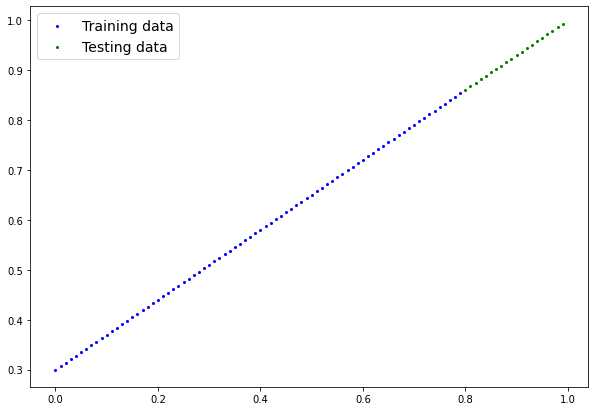

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels = Y_train_regression,
                 test_data = X_test_regression,
                 test_labels = Y_test_regression)

## 5.2. Adjusting `model_1` to fit a straight line

Now we've got some data, let's recreate `model_1` but with a loss function suited to our regression data.

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, Y_train_regression = X_train_regression.to(device), Y_train_regression.to(device)
X_test_regression, Y_test_regression = X_test_regression.to(device), Y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  Y_pred = model_2(X_train_regression)

  # 2. Calculate the loss
  loss = loss_fn(Y_pred, Y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_2(X_test_regression)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, Y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Train loss:{loss:.5f}, Test loss:{test_loss:.5f}")

Epoch:0 | Train loss:0.75986, Test loss:0.54143
Epoch:100 | Train loss:0.09309, Test loss:0.02901
Epoch:200 | Train loss:0.07376, Test loss:0.02850
Epoch:300 | Train loss:0.06745, Test loss:0.00615
Epoch:400 | Train loss:0.06107, Test loss:0.02004
Epoch:500 | Train loss:0.05698, Test loss:0.01061
Epoch:600 | Train loss:0.04857, Test loss:0.01326
Epoch:700 | Train loss:0.06109, Test loss:0.02127
Epoch:800 | Train loss:0.05599, Test loss:0.01426
Epoch:900 | Train loss:0.05571, Test loss:0.00603


Since our model and data are using the target `device`, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handel that, we'll send all of our data to the CPU using `.cpu()` when we pass it to `plot_predictions()`.

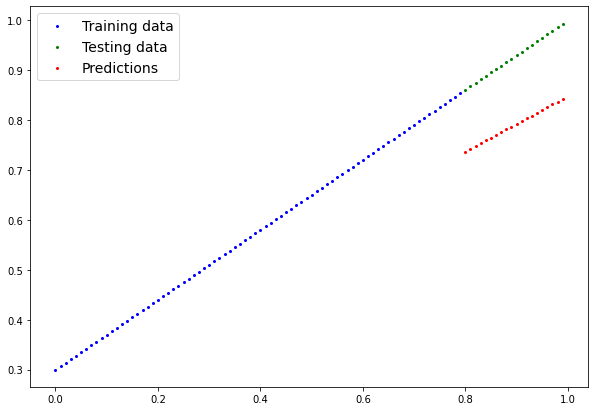

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  Y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = Y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = Y_test_regression.cpu(),
                 predictions = Y_preds.cpu())

It looks like our model is able to do far better than random guessing on straight lines. It means our model at least has *some* capacity to learn.

> **Note**: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.
>
> This could mean **starting with a simple neural network** (not many layers, not many hidden neurons) and a small dataset and then **overfitting** (making the model perform too well) on that small example before increasing the amount data or the model size/design to *reduce* overfitting.

# 6) Non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers. But how about we give it the capacity to draw non-straight (non-linear) lines?

## 6.1. Recreating non-linear data (red and blue circles)

First, let's recreate the data to star off fresh.

In [ ]:
import torch
from torch import nn

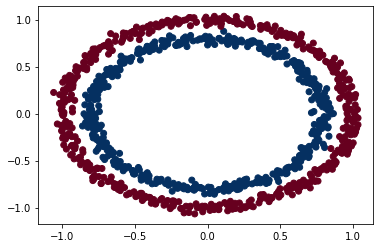

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples = 1000,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdBu);

In [ ]:
# Convert to tensors and split into train and test sets
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

# Split into train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train[:5], Y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

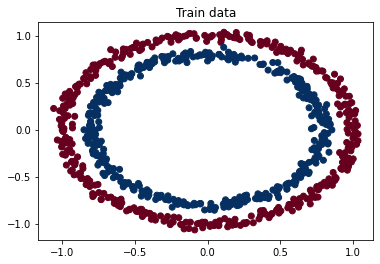

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.RdBu)
plt.title("Train data");

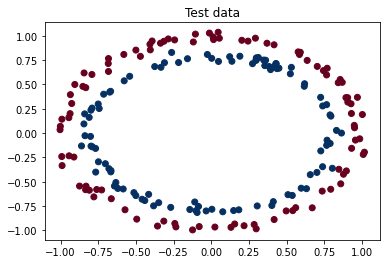

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.RdBu)
plt.title("Test data");

## 6.2. Building a model with non-linearity

What do you think will happen when we introduce the capability for our model to use **non-linear activation functions?**

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similar but different things.

One of the most common and best performing is **ReLU** (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html))

$$
\text{ReLU}(x)=(x)^+=\max(0,x)
$$

Let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [ ]:
# Build model with non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # add in ReLU activation function

  def forward(self, x):
    # Intersperse the ReLU activation function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


> **Question**: Where should I put the non-linear activation function when constructing a neural network?
>
> A rule of thumb is to put them in *between hidden layers and just after the output layer*. however, there is no set in stone option.

Now we've got a model ready to go, let's create a binary classification loss function as well as an optimizer.

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3. Training a model with non-linearity

In [ ]:
torch.manual_seed(42)
epochs = 1000

# Put data on target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  Y_logits = model_3(X_train).squeeze()
  Y_pred = torch.round(torch.sigmoid(Y_logits))

  # 2. Calculation loss and accuracy
  loss = loss_fn(Y_logits, Y_train) # BCEWithLogitsLoss calculates loss using logits
  acc = accuracy_fn(y_true = Y_train, y_pred = Y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss and accuracy
    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(y_true = Y_test, y_pred = test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


## 6.4. Evaluating a model trained with non-linear activation functions



In [ ]:
# Make predictions
with torch.inference_mode():
  Y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
Y_preds[:10], Y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

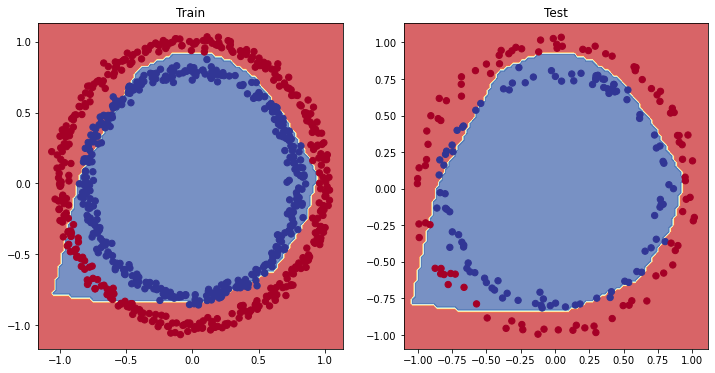

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, Y_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, Y_test) 

# 7) Replicating non-linear activation functions

Let's start by creating a small amount of data.

In [ ]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

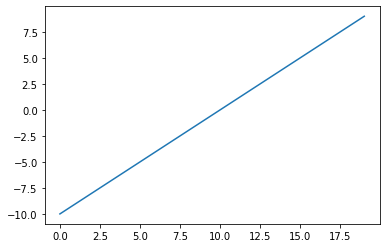

In [ ]:
# Visualize the toy tensor
plt.plot(A);

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (`torch.nn.ReLU`) we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

$$
\text{ReLU}(x)=(x)^+=\max(0,x)
$$

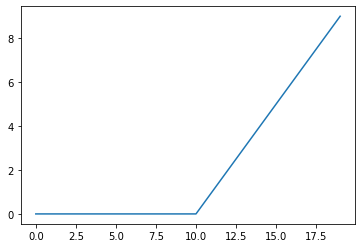

In [ ]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Plot ReLU activated toy tensor
plt.plot(relu(A));

How about we try the sigmoid function we've been using?

The sigmoid function formula goes like so:

$$
S(x)=\frac{1}{1+\exp(-x)}
$$

Let's build a funcion to replicate the sigmoid function with PyTorch.

In [ ]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

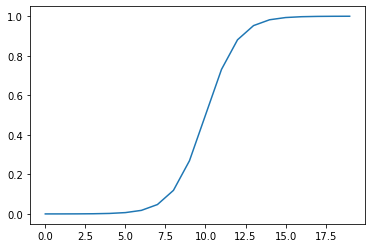

In [ ]:
# Plor sigmoid activated toy tensor
plt.plot(sigmoid(A));

Now there's plenty more [non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that exist in PyTorch, but these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.

# 8) Multi-class classification

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png" width=900/>

## 8.1. Creating multi-class classification data

* Using the Scikit-Learn's `make_blobs()` method. This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:
1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors.
3. Split the data into training and test sets.
4. Visualize the data.

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


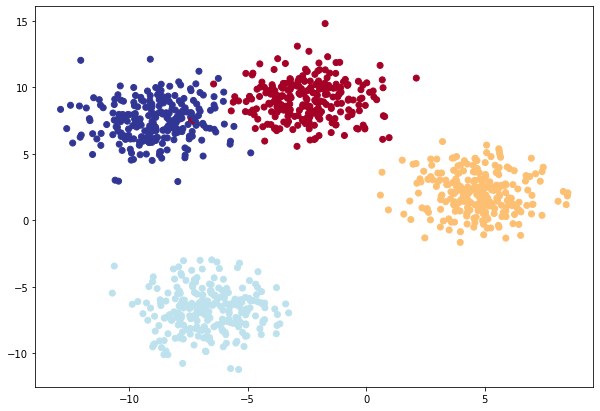

In [ ]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, Y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)
print(X_blob[:5], Y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, Y_blob_train, Y_blob_test = train_test_split(X_blob, 
                                                                        Y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap=plt.cm.RdYlBu);

> **Question**: Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

## 8.2 Building a multi-class classification model in PyTorch

Let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideas number of outputs features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model.
      out_features (int): Number of output features of the model.
      hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # <- does our dataset requiere non-linear layer?
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # <- does our dataset requiere non-linear layer?
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3. Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

## 8.4. Getting prediction probabilities for a multi-class PyTorch model

Let's do a single forward pass with our model to see if it works.

In [ ]:
# Perform a single forward pass on the data
model_4(X_blob_train.to(device))[:5]

tensor([[-0.4552,  0.3025, -0.7895, -0.1896],
        [-0.3207,  0.3175, -0.6448, -0.3633],
        [-0.7049,  0.1271, -0.3468, -0.5244],
        [-0.3780,  0.0526, -0.3058, -0.4354],
        [-0.1196,  0.1643, -0.4806, -0.3184]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

`logits -> prediction probabilities -> prediction labels`.

That's where the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

> The **Softmax function** takes as input a vector $z$ of $K$ real numbers, and normalized it into a *probability distribution* consisting of $K$ probabilities proportional to the exponentials of the input numbers.
>
> That is, prior to applying softmax, some vector components could be negative, or greater than one; and might not sum to $1$; but after applying softmax, each component will be in the interval $(0, 1)$, and the components will add up to $1$.
>
> The standard (unit) softmax function $\sigma : \mathbb{R}^K\to[0,1]^{K}$ is greater than one by the formula:
>$$ \sigma(\mathbf{z})_i = \frac{\exp{z_i}}{\sum_{j=1}^{K}\exp{z_j}}$$
>
>In simple words, it applies the standard exponential function to each element $z_i$ of the input vector $\mathbf{z}$ and normalizes these values by dividing by the sum of all these exponentials; this normalization ensures that the sum of the components of the output vector $\sigma(\mathbf{z})$ is $1$.

In [ ]:
# Make prediction logits with model
Y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get predictions probabilities
Y_pred_probs = torch.softmax(Y_logits, dim=1)
print(Y_logits[:5])
print(Y_pred_probs[:5])

tensor([[-0.4985,  0.3042, -0.8699, -0.2257],
        [ 0.0923,  0.0769, -0.3393, -0.3591],
        [-0.5457,  0.0908, -0.3268, -0.4811],
        [-0.2039,  0.1631, -0.5381, -0.2075],
        [-0.5090,  0.4635, -0.7972, -0.4018]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1910, 0.4263, 0.1318, 0.2509],
        [0.3057, 0.3010, 0.1986, 0.1947],
        [0.1923, 0.3634, 0.2393, 0.2051],
        [0.2406, 0.3473, 0.1723, 0.2398],
        [0.1816, 0.4802, 0.1361, 0.2021]], device='cuda:0',
       grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(Y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

These prediction probabilites are essentially saying how much the model *thinks* the target `X` sample (the input) maps to each class.

Since there's one value for each class in `Y_pred_probs`, the index of the *highest* values is the class the model thinks the specific data sample *most* belong to.

We can check which index has the highest value using `torch.argmax()`.

In [ ]:
# Which class does the model think is most likely at the index 0 sample?
print(Y_pred_probs[0])
print(torch.argmax(Y_pred_probs[0]))

tensor([0.1910, 0.4263, 0.1318, 0.2509], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


>**Note**: To summarize the above, a model's raw output is referred to as **logits**.
>
> For a multi-class classification problem, to turn the logits into **prediction probabilities**, you use the softmax activation function (`torch.softmax`).
>
>The index of the value with the highest **prediction probability** is the class number the model thinks is *most* likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

## 8.5. Creating a training and testing loop for multi-class PyTorch model

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilites (using the softmax activation function) and then to prediction lables (by making the argmax of the output of the softmax activation function).

Let's train the model for `epochs = 100` and evaluate it every 10 epochs.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_blob_train, Y_blob_train = X_blob_train.to(device), Y_blob_train.to(device)
X_blob_test, Y_blob_test = X_blob_test.to(device), Y_blob_test.to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  Y_logits = model_4(X_blob_train) # model outputs raw logits
  Y_pred = torch.softmax(Y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(Y_logits, Y_blob_train)
  acc = accuracy_fn(y_true=Y_blob_train,
                    y_pred=Y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, Y_blob_test)
    test_acc = accuracy_fn(y_true=Y_blob_test,
                           y_pred=test_pred)
    
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.37260, Accuracy: 26.12% | Test Loss: 1.34196, Test Accuracy: 20.00%
Epoch: 10 | Loss: 0.83154, Accuracy: 67.75% | Test Loss: 0.83485, Test Accuracy: 64.50%
Epoch: 20 | Loss: 0.59539, Accuracy: 75.50% | Test Loss: 0.62404, Test Accuracy: 70.50%
Epoch: 30 | Loss: 0.46125, Accuracy: 81.38% | Test Loss: 0.49700, Test Accuracy: 76.00%
Epoch: 40 | Loss: 0.37749, Accuracy: 91.50% | Test Loss: 0.41274, Test Accuracy: 89.50%
Epoch: 50 | Loss: 0.32077, Accuracy: 96.00% | Test Loss: 0.35248, Test Accuracy: 96.00%
Epoch: 60 | Loss: 0.27832, Accuracy: 97.50% | Test Loss: 0.30576, Test Accuracy: 98.00%
Epoch: 70 | Loss: 0.24521, Accuracy: 97.88% | Test Loss: 0.26923, Test Accuracy: 98.50%
Epoch: 80 | Loss: 0.21876, Accuracy: 97.88% | Test Loss: 0.23970, Test Accuracy: 99.00%
Epoch: 90 | Loss: 0.19691, Accuracy: 98.25% | Test Loss: 0.21499, Test Accuracy: 99.00%


## 8.6. Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  Y_logits = model_4(X_blob_test)

# View the first 10 predictions
Y_logits[:10]

tensor([[-0.2186,  5.1221, -6.4843, -3.5129],
        [-0.2986, -0.5291, -0.6284,  0.9496],
        [-8.5592, -1.8597,  5.8512, -0.0486],
        [-1.4668,  3.5536, -3.8274, -1.3973],
        [ 5.2819,  0.6204, -5.9542, -3.6612],
        [-0.2986, -0.5291, -0.6284,  0.9496],
        [-8.5625, -1.8459,  5.8571, -0.0365],
        [ 4.0563, -0.4708, -3.8810, -2.0130],
        [-9.1203, -2.0851,  6.2459, -0.2390],
        [ 4.8274, -0.4407, -4.4887, -2.5602]], device='cuda:0')

To evaluate the predicitons, they'll have to be in the same form as our labels (`Y_blob_test`) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using `torch.softmax()`) then to prediction lables (by taking the `argmax()` of each sample).

> **Note**: It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.
>
> For example, `Y_preds = torch.argmax(Y_logits, dim=1)`, this saves a computation step but results in no prediction probabilites being available to use. 

In [ ]:
# Turn predicted logits in prediction probabilites
Y_pred_probs = torch.softmax(Y_logits, dim=1)

# Turn predictions probabilites into prediction labels
Y_preds = Y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {Y_preds[:10]}\nLabels: {Y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=Y_blob_test, y_pred=Y_preds)}")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5


Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

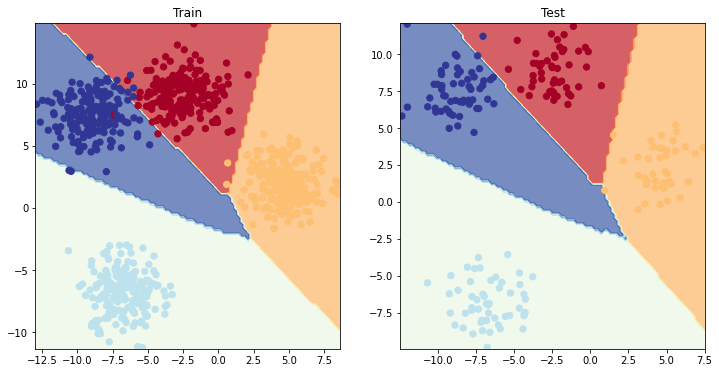

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, Y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, Y_blob_test)